In [2]:
using QuantEcon, Interpolations, Plots

In [3]:
struct Parameters
    α_1::Float64
    α_2::Float64
    γ_h::Float64
    intercept::Float64
    age1::Float64
    age2::Float64
    age3::Float64
    child::Float64
    interact::Float64
    ρ::Float64
    σ::Float64
    gp_ν_s::Int64
    grid_ν_s::Vector{Float64}
    markov::Matrix{Float64}
    aux_ages::Array{Int64}
    aux_ν::Array{Float64}
    #int_ν_j = interpolate(knots, aux_ν, Gridded(Linear()))
    #min_h::Float64
    #max_h::Float64
    gp_h::Int64
    grid_h::Vector{Float64}
    J::Int64
    β::Float64

    function Parameters(α_1 = 0.351;
                        α_2 = 0.379,
                        γ_h = 1.0,
                        intercept = 0.196,
                        age1 = 3.32,
                        age2 = -0.086,
                        age3 = 0.0007,
                        child = -6.81,
                        interact = 0.133,
                        ρ = 0.76,
                        σ = 0.79,
                        ν_s = 1,
                        gp_ν_s = 7,
                        aux_ages = [17, 20, 25, 30, 40, 50, 55, 60, 65],
                        aux_ν = [8.0, 1.12, 0.42, 0.29, 0.25, 0.24, 0.25, 0.34, 1.6],
                        min_h = 0.0001,
                        max_h = 200,
                        gp_h = 101,
                        J = 4*(65-20),
                        β = 0.99)
        grid_h = collect(range(min_h, stop = max_h, length=gp_h))
        m = QuantEcon.tauchen(gp_ν_s,ρ,σ,0,1)
        markov = m.p
        grid_ν_s = exp.(collect(m.state_values))
        new(α_1, α_2, γ_h, intercept, age1, age2, age3, child, interact, ρ, σ, gp_ν_s, grid_ν_s, markov, aux_ages, aux_ν,  gp_h, grid_h, J, β)
    end
end

In [4]:
function c(j,h,P::Parameters)
    return (P.α_1+j^(P.α_2))*h^(P.γ_h)
end
function HCA(c,V_hat,V_hat_delta)
    e = max(1-c/(V_hat_delta-V_hat),0) #closed form solution of optimal effort
    if e>1
        error("outside of definition")
    end
    return (c*log(1-e)+e*V_hat+(1-e)*V_hat_delta, e)
end

function l(j,n,P::Parameters)
    P.intercept+P.age1*j+P.age2*j^2+P.age3*j^3+P.child*n+P.interact*n*j
end

function W(j,h,n,ν,VV_hat,VV_hat_delta,ll,P::Parameters)
    cc = c(j,h,P)
    (opt_HCA,e) = HCA(cc,VV_hat,VV_hat_delta)
    uu = h*ν
    aux_val = h*ll + (1-ll)*uu + P.γ_h*log(1+n) + opt_HCA
    return (aux_val, e)
end

function H(j,h,n,ν,γ_n,VV_hat)
    uu = h*ν
    return uu + γ_n*log(1+n)+VV_hat
end

function V(j,h,n,P::Parameters)
    max(H(j,h,n,P::Parameters),V(j,h,n,P::Parameters))
end

V (generic function with 1 method)

In [5]:
function male_policy(P::Parameters)
    W_value = Array{Float64}(undef, P.gp_h, P.J, P.gp_ν_s)
    H_value = Array{Float64}(undef, P.gp_h, P.J, P.gp_ν_s)
    V_value = Array{Float64}(undef, P.gp_h, P.J, P.gp_ν_s)
    labor_policy = Array{Float64}(undef, P.gp_h, P.J, P.gp_ν_s)
    effort_policy = Array{Float64}(undef, P.gp_h, P.J, P.gp_ν_s)
    knots = (P.aux_ages,)
    int_ν_j = interpolate(knots, P.aux_ν, Gridded(Linear()))

    #Last period
    ll = l(P.J,0,P)
    for (ind_h,h) in enumerate(P.grid_h)
        age = 20+P.J/4
        for (ind_ν, ν_s) in enumerate(P.grid_ν_s)
            ν = int_ν_j[age]*ν_s
            (W_value[ind_h,P.J,ind_ν], effort_policy[ind_h, P.J,ind_ν]) = W(P.J,h,0,ν,10^(-8),10^(-6),ll,P)
            H_value[ind_h,P.J,ind_ν]                                  = H(P.J,h,0,ν,P.γ_h,10^(-8))
            V_value[ind_h,P.J,ind_ν]                                  = max.(W_value[ind_h,P.J,ind_ν],H_value[ind_h,P.J,ind_ν])
            labor_policy[ind_h,P.J,ind_ν]                             = 1*(W_value[ind_h,P.J,ind_ν]>H_value[ind_h,P.J,ind_ν])
        end
    end
    #Backwards induction
    for j in P.J-1:-1:1
        #j=J-1
        age = 20+j/4
        ll = l(j,0,P)
        #println(age)
        itp_h = interpolate((P.grid_h,P.grid_ν_s),V_value[:,j+1,:],Gridded(Linear()))
        etp_h = extrapolate(itp_h, Line())
        for (ind_h,h) in enumerate(P.grid_h)
            h_delta = h*1.03
            for (ind_ν, ν_s) in enumerate(P.grid_ν_s)
                contval = 0
                contval_delta = 0
                for (ind_ν_2, ν_s_2) in enumerate(P.grid_ν_s)
                    contval       = contval      + P.markov[ind_ν,ind_ν_2]*etp_h[h,ν_s_2]
                    contval_delta = contval_delta+ P.markov[ind_ν,ind_ν_2]*etp_h[h_delta,ν_s_2]
                end
                ν = int_ν_j[age]*ν_s
                (W_value[ind_h,j,ind_ν], effort_policy[ind_h, j,ind_ν]) = W(j, h, 0, ν, contval, contval_delta, ll, P)
                H_value[ind_h,j,ind_ν] = H(j,h,0,ν,P.γ_h, contval)
                V_value[ind_h,j,ind_ν] = max.(W_value[ind_h,j,ind_ν],H_value[ind_h,j,ind_ν])
                labor_policy[ind_h,j,ind_ν] = 1*(W_value[ind_h,j,ind_ν]>H_value[ind_h,j,ind_ν])
            end
        end
    end
    return (W_value, H_value, V_value, labor_policy, effort_policy)
end

male_policy (generic function with 1 method)

In [6]:
P = Parameters()

Parameters(0.351, 0.379, 1.0, 0.196, 3.32, -0.086, 0.0007, -6.81, 0.133, 0.76, 0.79, 7, [0.296553, 0.444701, 0.666859, 1.0, 1.49957, 2.2487, 3.37208], [0.455081 0.200358 … 0.0191578 0.00711168; 0.307614 0.196478 … 0.0410885 0.0196142; … ; 0.0196142 0.0410885 … 0.196478 0.307614; 0.00711168 0.0191578 … 0.200358 0.455081], [17, 20, 25, 30, 40, 50, 55, 60, 65], [8.0, 1.12, 0.42, 0.29, 0.25, 0.24, 0.25, 0.34, 1.6], 101, [0.0001, 2.0001, 4.0001, 6.0001, 8.0001, 10.0001, 12.0001, 14.0001, 16.0001, 18.0001  …  182.0, 184.0, 186.0, 188.0, 190.0, 192.0, 194.0, 196.0, 198.0, 200.0], 180, 0.99)

In [7]:
(W_value, H_value, V_value, labor_policy, effort_policy) = male_policy(P)

([2.97944 2.97941 … 0.157393 0.0995702; 59591.8 59591.1 … 3148.0 1991.48; … ; 5.8993e6 5.89923e6 … 3.11636e5 1.97147e5; 5.95889e6 5.95882e6 … 3.14784e5 1.99138e5]

[2.97945 2.97936 … 0.100575 0.054704; 59592.0 59590.2 … 2011.59 1094.11; … ; 5.89931e6 5.89914e6 … 1.99137e5 1.08312e5; 5.9589e6 5.95872e6 … 2.01149e5 1.09406e5]

[2.97945 2.97928 … 0.0238953 -0.012576; 59592.0 59588.6 … 477.923 -251.552; … ; 5.89931e6 5.89898e6 … 47312.0 -24902.4; 5.9589e6 5.95856e6 … 47789.9 -25154.0]

[2.97943 2.97915 … -0.0821323 -0.113467; 59591.6 59585.9 … -1642.73 -2269.47; … ; 5.89928e6 5.89872e6 … -1.62622e5 -2.24666e5; 5.95886e6 5.9583e6 … -164265.0 -2.26936e5]

[2.97938 2.97893 … -0.232258 -0.264759; 59590.5 59581.5 … -4645.4 -5295.47; … ; 5.89917e6 5.89828e6 … -4.59872e5 -5.24225e5; 5.95875e6 5.95785e6 … -4.64517e5 -5.2952e5]

[2.97926 2.97856 … -0.450313 -0.491632; 59588.1 59574.2 … -9006.71 -9833.15; … ; 5.89893e6 5.89756e6 … -8.9162e5 -9.73434e5; 5.95852e6 5.95713e6 … -9.00627e5 -9.83267e5]

[

In [11]:
using Plots
pyplot()
plot(W_value,linewidth=2,title="My Plot")

ArgumentError: ArgumentError: Package Plot not found in current path:
- Run `import Pkg; Pkg.add("Plot")` to install the Plot package.


In [48]:
W_value[1,:,1]

180-element Array{Float64,1}:
 2.979443762537037  
 2.9794085752744928 
 2.9794262016666084 
 2.9794841413602002 
 2.979593316447758  
 2.9797107366547815 
 2.9798198163344343 
 2.97989676997511   
 2.9799395108789413 
 2.9799474827451946 
 2.979912643645785  
 2.9798223742779535 
 2.9796762523559344 
 ⋮                  
 0.5178978525207913 
 0.48057028583633904
 0.44434325200792674
 0.40885465828441303
 0.3740657908330072 
 0.33987123555515386
 0.30605363241468225
 0.2722027251596436 
 0.23755187748838225
 0.20055969230781476
 0.1573926330348343 
 0.0995702304222464 

In [54]:
#plot wage based on human capital in the left column and time in the x column

W_sub_1 =  W_value[1,:,:]

plot(W_sub_1[1,:])

for i in 2:101
    plot!(W_sub_1[i,:])
end


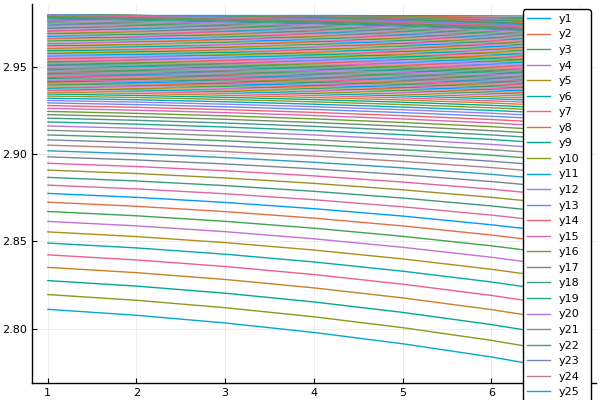

In [55]:
display(plot!())

In [60]:
#plot wage based on human capital in the left column and time in the x column

H_value_1 =  H_value[1,:,:]

plot(H_value_1[1,:])

for i in 2:101
    plot!(H_value_1[i,:])
end


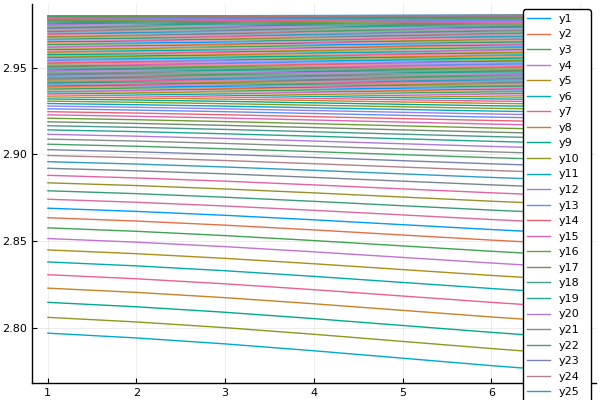

In [61]:
display(plot!())

In [63]:
#plot wage based on human capital in the left column and time in the x column

V_value_1 =  V_value[1,:,:]

plot(V_value_1[1,:])

for i in 2:101
    plot!(V_value_1[i,:])
end


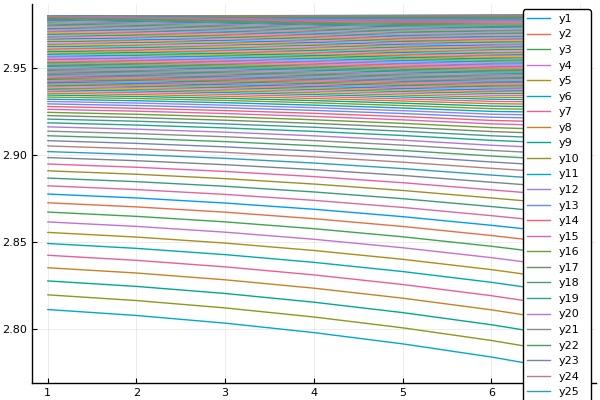

In [64]:
display(plot!())

In [70]:
#plot wage based on human capital in the left column and time in the x column

labor_policy_1 =  labor_policy[1,:,:]

plot(labor_policy_1[1,:])

for i in 2:101
    plot!(labor_policy_1[i,:])
end


In [ ]:
labor_policy_1

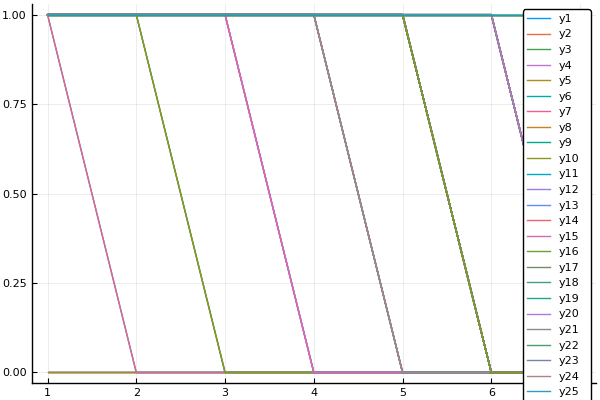

In [71]:
display(plot!())

In [ ]:
#plot wage based on human capital in the left column and time in the x column

effort_policy_1 = effort_policy[4,:,:]

plot(effort_policy_1[1,:])

for i in 2:101
    plot!(effort_policy_1[i,:])
end


In [ ]:
display(plot!())